In [ ]:
# ============================================================
# PIPELINE FOR PLASMA + GENOTYPE MODEL
# ============================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# ------------------------------------------------------------
# 1. LOAD RAW DATA
# ------------------------------------------------------------
path = "data/"
df = pd.read_csv(path)

# ------------------------------------------------------------
# 2. Convert VISCODE to numeric month index
# ------------------------------------------------------------
def convert_viscode(x):
    x = str(x).strip().lower()
    if x == "bl": 
        return 0
    if x.startswith("m"):
        try:
            return int(x[1:])   # m06→6, m12→12...
        except:
            return np.nan
    return np.nan

df["VISCODE_month"] = df["VISCODE2_x"].apply(convert_viscode)

# ------------------------------------------------------------
# 3. Select required columns
# ------------------------------------------------------------
cols = [
    "PTID", "VISCODE_month",
    "ABETA40","ABETA42","TAU","PTAU",
    "DIAGNOSIS","GENOTYPE"
]
df = df[cols].copy()

# Drop rows with missing biomarker or VISCODE
df = df.dropna(subset=["VISCODE_month","ABETA40","ABETA42","TAU","PTAU","DIAGNOSIS","GENOTYPE"])

# ------------------------------------------------------------
# 4. Encode DIAGNOSIS (1,2 = non-AD, 3 = AD)
# ------------------------------------------------------------
df["DX_binary"] = df["DIAGNOSIS"].apply(lambda x: 1 if x == 3 else 0)

# ------------------------------------------------------------
# 5. Encode APOE genotype → e4 allele count
# ------------------------------------------------------------
def count_e4(gen):
    if not isinstance(gen,str):
        return np.nan
    alleles = gen.replace(" ","").split("/")
    return sum(1 for a in alleles if a == "4")

df["APOE_e4_count"] = df["GENOTYPE"].apply(count_e4)

# ------------------------------------------------------------
# 6. Compute baseline & slope for each biomarker
# ------------------------------------------------------------
biomarkers = ["ABETA40","ABETA42","TAU","PTAU"]

def compute_baseline_slope(group):
    if len(group) < 2:
        return None   # cannot compute slope

    result = {}

    # Sort by VISCODE
    group_sorted = group.sort_values("VISCODE_month")

    for biom in biomarkers:
        # baseline
        result[f"{biom}_baseline"] = group_sorted.iloc[0][biom]

        # slope via linear regression
        X = group_sorted["VISCODE_month"].values.reshape(-1,1)
        y = group_sorted[biom].values
        slope = LinearRegression().fit(X,y).coef_[0]
        result[f"{biom}_slope"] = slope

    # Add diagnosis + genotype
    result["DX_binary"] = group_sorted["DX_binary"].iloc[0]
    result["APOE_e4_count"] = group_sorted["APOE_e4_count"].iloc[0]

    return pd.Series(result)

longitudinal_df = df.groupby("PTID").apply(compute_baseline_slope)
longitudinal_df = longitudinal_df.dropna()
print("After slope/baseline computation:", longitudinal_df.shape)

# ------------------------------------------------------------
# 7. Build feature matrix
# ------------------------------------------------------------
feature_cols = []
for b in biomarkers:
    feature_cols += [f"{b}_baseline", f"{b}_slope"]

feature_cols += ["APOE_e4_count"]

X = longitudinal_df[feature_cols]
y = longitudinal_df["DX_binary"]

# ------------------------------------------------------------
# 8. Scale features
# ------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 9. Fix class imbalance via SMOTE
# ------------------------------------------------------------
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_scaled, y)

print("After SMOTE:", np.bincount(y_bal))

In [13]:
# ============================================================
# 10. MACHINE LEARNING MODELS + GRIDSEARCHCV + PLOTS
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 10.1 Define models + parameter grids
# ------------------------------------------------------------
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=500),
        {"C": [0.01, 0.1, 1, 10]}
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {"n_estimators": [200, 300], "max_depth": [None, 5, 10]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {"learning_rate": [0.01, 0.05, 0.1], "n_estimators": [100, 200]}
    ),
    "SVM (RBF)": (
        SVC(probability=True),
        {"C": [0.1, 1, 5], "gamma": ["scale", 0.1]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7]}
    ),
    "MLP": (
        MLPClassifier(max_iter=500),
        {"hidden_layer_sizes": [(32,), (64,), (32,16)],
         "alpha": [0.0001, 0.001]}
    )
}

# ------------------------------------------------------------
# 10.2 Train-test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# ------------------------------------------------------------
# 10.3 Run GridSearchCV for all models
# ------------------------------------------------------------
results = {}
all_fpr, all_tpr = {}, {}

for name, (model, param_grid) in models.items():
    print(f"\n===== TRAINING {name} =====")
    grid = GridSearchCV(model, param_grid, cv=5, scoring="roc_auc")
    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    y_prob = best.predict_proba(X_test)[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Best params:", grid.best_params_)
    print("Accuracy:", acc)
    print("AUC:", auc)

    results[name] = {"model": best, "acc": acc, "auc": auc}

    # ROC curve values
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    all_fpr[name] = fpr
    all_tpr[name] = tpr


===== TRAINING Logistic Regression =====
Best params: {'C': 10}
Accuracy: 0.8061224489795918
AUC: 0.8691748808366885

===== TRAINING Random Forest =====
Best params: {'max_depth': None, 'n_estimators': 300}
Accuracy: 0.8979591836734694
AUC: 0.9717478828266001

===== TRAINING Gradient Boosting =====
Best params: {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy: 0.8775510204081632
AUC: 0.9414133000138831

===== TRAINING SVM (RBF) =====
Best params: {'C': 5, 'gamma': 'scale'}
Accuracy: 0.891156462585034
AUC: 0.9355823962237957

===== TRAINING KNN =====
Best params: {'n_neighbors': 3}
Accuracy: 0.8945578231292517
AUC: 0.9625387569993984

===== TRAINING MLP =====


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}
Accuracy: 0.9081632653061225
AUC: 0.9515479661252255


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
import pandas as pd

summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [results[m]["acc"] for m in results],
    "AUC": [results[m]["auc"] for m in results],
})

print(summary)

                 Model  Accuracy       AUC
0  Logistic Regression  0.806122  0.869175
1        Random Forest  0.908163  0.972002
2    Gradient Boosting  0.877551  0.941043
3            SVM (RBF)  0.891156  0.935606
4                  KNN  0.894558  0.962539
5                  MLP  0.921769  0.944005


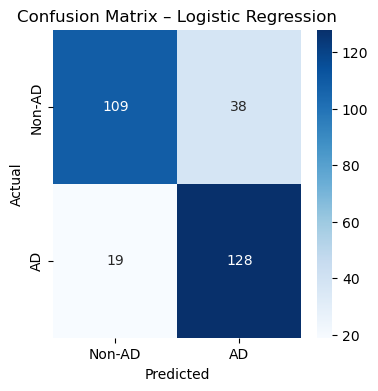

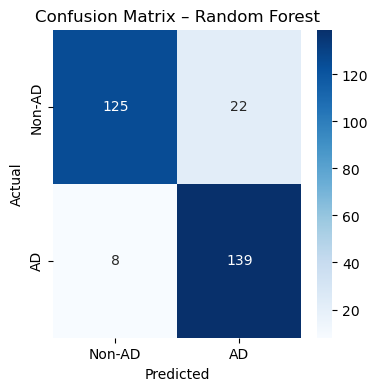

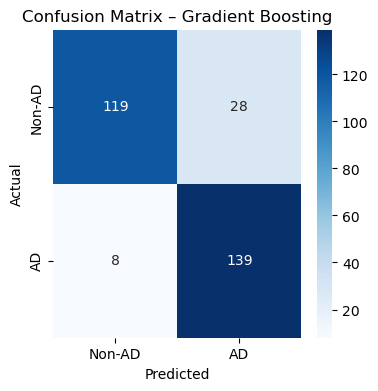

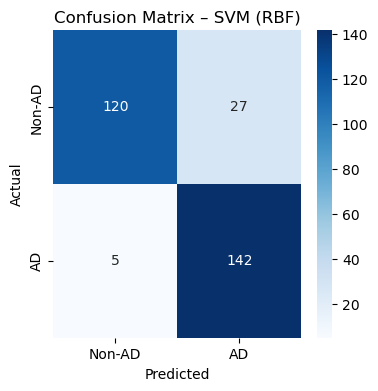

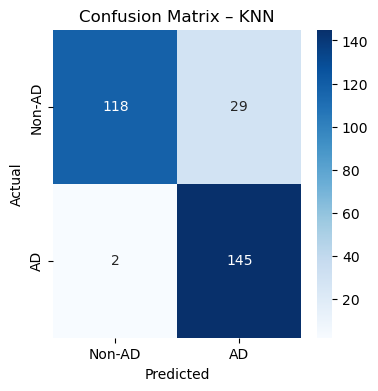

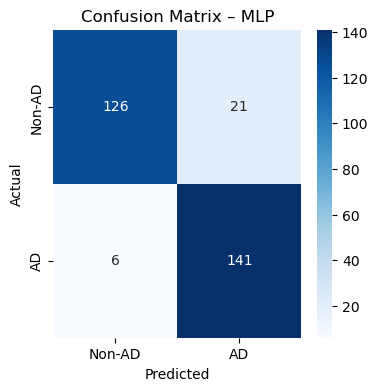

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFUSION MATRICES FOR ALL MODELS
# ============================================================

for name, info in results.items():
    model = info["model"]

    # predictions
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plot
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-AD', 'AD'],
                yticklabels=['Non-AD', 'AD'])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [24]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# ============================================================
# METRICS TABLE FOR ALL MODELS
# ============================================================

metrics_rows = []

for name, info in results.items():
    model = info["model"]

    # predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    # confusion matrix → specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-8)

    # append metrics
    metrics_rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
    })

# convert to DataFrame
metrics_table = pd.DataFrame(metrics_rows)

print("\n=============== MODEL PERFORMANCE TABLE ===============\n")
print(metrics_table)


=============== MODEL PERFORMANCE TABLE ===============

                 Model  Accuracy       AUC  Precision    Recall  F1 Score
0  Logistic Regression  0.806122  0.869175   0.771084  0.870748  0.817891
1        Random Forest  0.897959  0.971748   0.863354  0.945578  0.902597
2    Gradient Boosting  0.877551  0.941413   0.832335  0.945578  0.885350
3            SVM (RBF)  0.891156  0.935582   0.840237  0.965986  0.898734
4                  KNN  0.894558  0.962539   0.833333  0.986395  0.903427
5                  MLP  0.908163  0.951548   0.870370  0.959184  0.912621


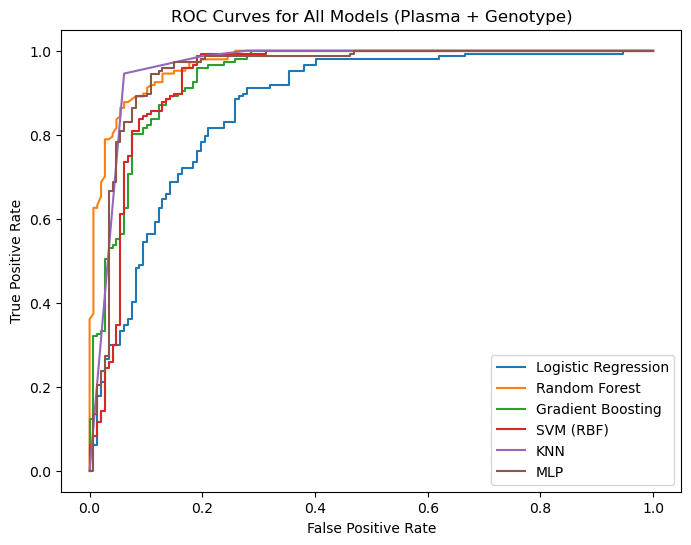

In [20]:
plt.figure(figsize=(8,6))

for name in results:
    plt.plot(all_fpr[name], all_tpr[name], label=name)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models (Plasma + Genotype)")
plt.legend()
plt.show()

In [53]:
rf_model = results["Random Forest"]["model"]

In [55]:
feature_cols = [
    'ABETA40_baseline',
    'ABETA40_slope',
    'ABETA42_baseline',
    'ABETA42_slope',
    'TAU_baseline',
    'TAU_slope',
    'PTAU_baseline',
    'PTAU_slope',
    'APOE_e4_count'
]

import pandas as pd
X_test_df = pd.DataFrame(X_test, columns=feature_cols)

shap_values.shape: (294, 9, 2)
shap_vals_ad.shape: (294, 9)
X_test_df.shape: (294, 9)


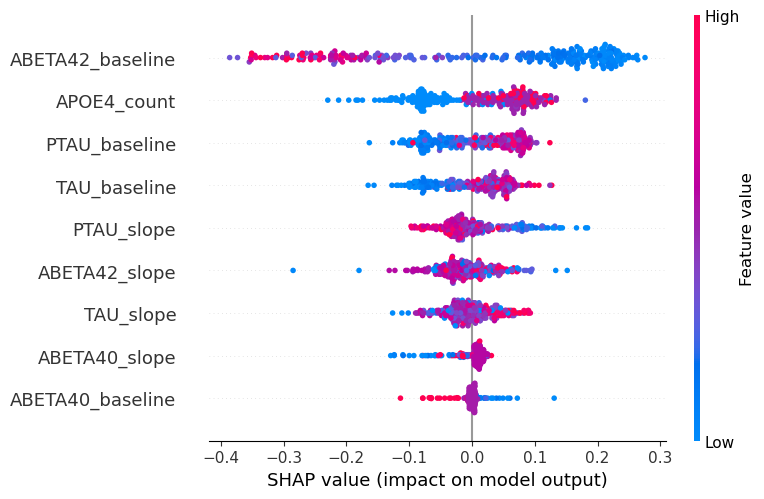

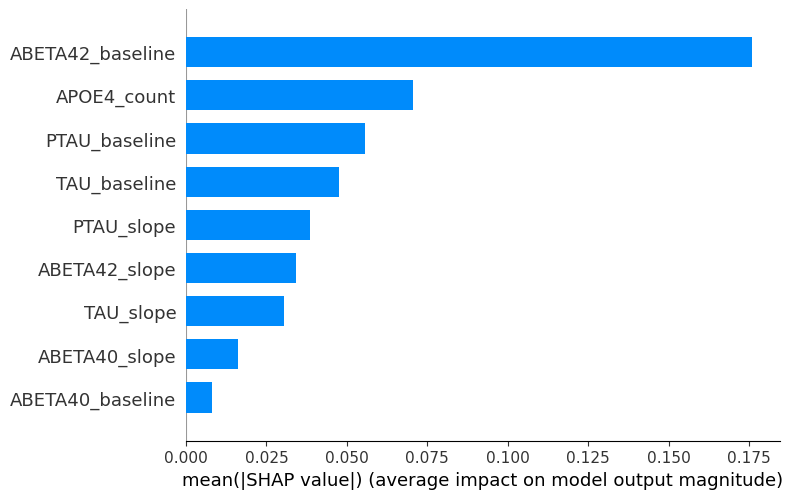

In [61]:
import shap
import numpy as np

rf_model = results["Random Forest"]["model"]

feature_cols = [
    'ABETA40_baseline',
    'ABETA40_slope',
    'ABETA42_baseline',
    'ABETA42_slope',
    'TAU_baseline',
    'TAU_slope',
    'PTAU_baseline',
    'PTAU_slope',
    'APOE4_count'
]

X_test_df = pd.DataFrame(X_test, columns=feature_cols)

# ---- SHAP ----
shap.initjs()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_df)   

print("shap_values.shape:", shap_values.shape)   

shap_vals_ad = shap_values[:, :, 1]

print("shap_vals_ad.shape:", shap_vals_ad.shape) 
print("X_test_df.shape:", X_test_df.shape)       

shap.summary_plot(shap_vals_ad, X_test_df)

shap.summary_plot(shap_vals_ad, X_test_df, plot_type="bar")

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
path = "data/"
df = pd.read_csv(path)

print("Original shape:", df.shape)

Original shape: (3174, 9)


In [3]:
def convert_viscode(x):
    if pd.isna(x):
        return np.nan
        
    x = str(x).strip().lower()

    if x == "bl":
        return 0

    if x.startswith("m"):
        try:
            return int(x[1:])
        except:
            return np.nan

    return np.nan

df["VISCODE_month"] = df["VISCODE2_x"].apply(convert_viscode)

In [5]:
print(df["VISCODE_month"].unique()[:20])

[  0  12  24  48  60  96 120  84  72 108  36  30  18 132 138 144  78  90
  66  54]


In [7]:
df["y"] = df["DIAGNOSIS"].map({1: 0, 2: 0, 3: 1})
print(df["y"].value_counts())

y
0    2777
1     397
Name: count, dtype: int64


In [9]:
def genotype_to_e4(g):
    if pd.isna(g):
        return np.nan
    a, b = str(g).split("/")
    return (a == "4") + (b == "4")

df["APOE4_count"] = df["GENOTYPE"].apply(genotype_to_e4)

In [11]:
df["APOE4_count"].value_counts(dropna=False)

APOE4_count
0.0    1789
1.0    1094
2.0     290
NaN       1
Name: count, dtype: int64

In [107]:
import numpy as np
from sklearn.linear_model import LinearRegression

dynamic_features = ["ABETA40", "ABETA42", "TAU", "PTAU"]

baseline_dict = {}
slope_dict = {}

for ptid, g in df.groupby("PTID"):
    g = g.sort_values("VISCODE_month")

    X = g[dynamic_features].values
    t = g["VISCODE_month"].values.reshape(-1, 1)

    # baseline biomarkers
    baseline_dict[ptid] = X[0]

    # slopes
    slopes = []
    for feat in dynamic_features:
        try:
            reg = LinearRegression().fit(t, g[feat].values)
            slopes.append(reg.coef_[0])
        except:
            slopes.append(0.0)
    slope_dict[ptid] = np.array(slopes)

In [109]:
seqs = []
statics = []
labels = []

for ptid, g in df.groupby("PTID"):
    g = g.sort_values("VISCODE_month")

    # sequence (T × 4)
    X_seq = g[dynamic_features].values.astype(np.float32)

    # static features (9)
    apoe4 = g["APOE4_count"].iloc[0]
    baseline_vals = baseline_dict[ptid]
    slope_vals = slope_dict[ptid]

    static_vector = np.concatenate([
        [apoe4], baseline_vals, slope_vals
    ])

    y_label = g["y"].iloc[-1]   # final diagnosis

    seqs.append(torch.tensor(X_seq))
    statics.append(torch.tensor(static_vector))
    labels.append(y_label)

In [111]:
from torch.nn.utils.rnn import pad_sequence

labels = torch.tensor(labels).float()

padded_seqs = pad_sequence(seqs, batch_first=True)  

static_tensors = torch.stack([torch.tensor(s, dtype=torch.float32) for s in statics])

print("Padded sequence shape:", padded_seqs.shape)
print("Static feature shape:", static_tensors.shape)
print("Labels shape:", labels.shape)

Padded sequence shape: torch.Size([1660, 10, 4])
Static feature shape: torch.Size([1660, 9])
Labels shape: torch.Size([1660])


/var/folders/_8/75kfzcss4jj8rss0_gkvrd2w0000gn/T/ipykernel_1685/3145703643.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_tensors = torch.stack([torch.tensor(s, dtype=torch.float32) for s in statics])


In [113]:
from sklearn.model_selection import train_test_split

X_seq_train, X_seq_temp, X_static_train, X_static_temp, y_train, y_temp = train_test_split(
    padded_seqs, static_tensors, labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)

X_seq_val, X_seq_test, X_static_val, X_static_test, y_val, y_test = train_test_split(
    X_seq_temp, X_static_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train:", len(X_seq_train))
print("Val:", len(X_seq_val))
print("Test:", len(X_seq_test))

Train: 1162
Val: 249
Test: 249


In [115]:
from torch.utils.data import Dataset, DataLoader

class SeqStaticDataset(Dataset):
    def __init__(self, X_seq, X_static, y):
        self.X_seq = X_seq
        self.X_static = X_static
        self.y = y

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return (
            self.X_seq[idx].float(),
            self.X_static[idx].float(),
            self.y[idx].float()
        )

train_ds = SeqStaticDataset(X_seq_train, X_static_train, y_train)
val_ds   = SeqStaticDataset(X_seq_val,   X_static_val,   y_val)
test_ds  = SeqStaticDataset(X_seq_test,  X_static_test,  y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=32)
test_dl  = DataLoader(test_ds,  batch_size=32)

In [117]:
import torch
import torch.nn as nn

class StaticGRU(nn.Module):
    def __init__(self, seq_input_dim=4, static_dim=9, hidden_dim=64, num_layers=2):
        super().__init__()

        # ----- GRU for sequence -----
        self.gru = nn.GRU(
            input_size=seq_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # ----- Dropout for GRU output -----
        self.dropout = nn.Dropout(0.3)

        # ----- Fully-connected classifier -----
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, X_seq, X_static):
        """
        X_seq:   (B, T, 4)
        X_static:(B, 9)
        """

        output, h_n = self.gru(X_seq)

        h_final = h_n[-1]               

        h_final = self.dropout(h_final)

        combined = torch.cat([h_final, X_static], dim=1)

        logits = self.fc(combined)     
        return logits

In [119]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        # BCE loss per sample
        bce_loss = self.bce(logits, targets.unsqueeze(1))

        probs = torch.sigmoid(logits)
        p_t = probs * targets.unsqueeze(1) + (1 - probs) * (1 - targets.unsqueeze(1))

        focal_term = (1 - p_t) ** self.gamma

        loss = self.alpha * focal_term * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        else:
            return loss.sum()

In [121]:
import torch
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

model_static = StaticGRU().to(device)

criterion = FocalLoss(alpha=1.0, gamma=2.0)
optimizer = optim.Adam(model_static.parameters(), lr=1e-3)

EPOCHS = 25
best_val_loss = np.inf

for epoch in range(EPOCHS):
    # ------------------------
    # TRAIN
    # ------------------------
    model_static.train()
    train_loss = 0

    for X_seq, X_static, y in train_dl:
        X_seq, X_static, y = X_seq.to(device), X_static.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model_static(X_seq, X_static)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ------------------------
    # VALIDATION
    # ------------------------
    model_static.eval()
    val_loss = 0

    with torch.no_grad():
        for X_seq, X_static, y in val_dl:
            X_seq, X_static, y = X_seq.to(device), X_static.to(device), y.to(device)
            logits = model_static(X_seq, X_static)
            loss = criterion(logits, y)
            val_loss += loss.item()

    train_loss /= len(train_dl)
    val_loss /= len(val_dl)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_static.state_dict(), "best_static_gru.pth")
        print("   --> Best model saved.")

Device = cpu
Epoch 01 | Train Loss: 89.6347 | Val Loss: 42.7009
   --> Best model saved.
Epoch 02 | Train Loss: 57.6237 | Val Loss: 24.6681
   --> Best model saved.
Epoch 03 | Train Loss: 46.1663 | Val Loss: 24.0094
   --> Best model saved.
Epoch 04 | Train Loss: 32.8153 | Val Loss: 15.7057
   --> Best model saved.
Epoch 05 | Train Loss: 22.3687 | Val Loss: 15.5009
   --> Best model saved.
Epoch 06 | Train Loss: 18.5491 | Val Loss: 6.9442
   --> Best model saved.
Epoch 07 | Train Loss: 12.9099 | Val Loss: 4.1364
   --> Best model saved.
Epoch 08 | Train Loss: 8.6716 | Val Loss: 5.0748
Epoch 09 | Train Loss: 5.7463 | Val Loss: 1.2274
   --> Best model saved.
Epoch 10 | Train Loss: 3.0341 | Val Loss: 0.8286
   --> Best model saved.
Epoch 11 | Train Loss: 1.8350 | Val Loss: 0.4717
   --> Best model saved.
Epoch 12 | Train Loss: 0.9314 | Val Loss: 0.6579
Epoch 13 | Train Loss: 0.5246 | Val Loss: 0.2511
   --> Best model saved.
Epoch 14 | Train Loss: 0.2440 | Val Loss: 0.1616
   --> Best mo

In [123]:
model_static.load_state_dict(torch.load("best_static_gru.pth"))
model_static.eval()
print("Loaded best Static-GRU model.")

Loaded best Static-GRU model.


In [125]:
import torch
import torch.nn as nn

class FiLM_GRU(nn.Module):
    def __init__(self, seq_input_dim=4, static_dim=9, hidden_dim=64, num_layers=2):
        super().__init__()

        # GRU for longitudinal biomarkers
        self.gru = nn.GRU(
            input_size=seq_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(0.3)

        # -------------------------------
        # FiLM conditioning (uses ONLY APOE4)
        # -------------------------------
        condition_dim = 1  # APOE4_count
        
        self.gamma_layer = nn.Linear(condition_dim, hidden_dim)
        self.beta_layer  = nn.Linear(condition_dim, hidden_dim)

        # -------------------------------
        # The classifier receives:
        #   FiLM-modulated GRU state (hidden_dim)
        #   + 8 other static features (baseline + slopes)
        # -------------------------------
        other_static_dim = static_dim - 1  # remove APOE4

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + other_static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, X_seq, X_static):
        """
        X_seq:   (B, T, 4)
        X_static:(B, 9) → [APOE4, baseline(4), slopes(4)]
        """

        # Separate APOE4 and remaining static variables
        apoe4 = X_static[:, 0].unsqueeze(1)     # (B,1)
        other_static = X_static[:, 1:]          # (B,8)

        # ----- GRU -----
        output, h_n = self.gru(X_seq)
        h_last = h_n[-1]                        # (B, hidden_dim)
        h_last = self.dropout(h_last)

        # ----- FiLM conditioning -----
        gamma = self.gamma_layer(apoe4)         # (B, hidden_dim)
        beta  = self.beta_layer(apoe4)          # (B, hidden_dim)

        h_film = h_last * (1 + gamma) + beta    # FiLM-modulated GRU embedding

        # ----- Combine FiLM + remaining static -----
        combined = torch.cat([h_film, other_static], dim=1)

        logits = self.fc(combined)
        return logits

In [127]:
import torch
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

model_film = FiLM_GRU().to(device)

criterion = FocalLoss(alpha=1.0, gamma=2.0)
optimizer = optim.Adam(model_film.parameters(), lr=1e-3)

EPOCHS = 25
best_val_loss = np.inf

for epoch in range(EPOCHS):

    # ------------------------
    # TRAIN
    # ------------------------
    model_film.train()
    train_loss = 0

    for X_seq, X_static, y in train_dl:
        X_seq, X_static, y = (
            X_seq.to(device),
            X_static.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        logits = model_film(X_seq, X_static)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ------------------------
    # VALIDATION
    # ------------------------
    model_film.eval()
    val_loss = 0

    with torch.no_grad():
        for X_seq, X_static, y in val_dl:
            X_seq, X_static, y = (
                X_seq.to(device),
                X_static.to(device),
                y.to(device)
            )

            logits = model_film(X_seq, X_static)
            loss = criterion(logits, y)
            val_loss += loss.item()

    train_loss /= len(train_dl)
    val_loss /= len(val_dl)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_film.state_dict(), "best_film_gru.pth")
        print("   --> Best FiLM-GRU model saved.")

Device = cpu
Epoch 01 | Train Loss: 87.8819 | Val Loss: 28.4430
   --> Best FiLM-GRU model saved.
Epoch 02 | Train Loss: 54.8188 | Val Loss: 31.8377
Epoch 03 | Train Loss: 42.9610 | Val Loss: 22.3888
   --> Best FiLM-GRU model saved.
Epoch 04 | Train Loss: 32.1194 | Val Loss: 7.9041
   --> Best FiLM-GRU model saved.
Epoch 05 | Train Loss: 23.8238 | Val Loss: 15.6455
Epoch 06 | Train Loss: 14.4568 | Val Loss: 4.8073
   --> Best FiLM-GRU model saved.
Epoch 07 | Train Loss: 9.6264 | Val Loss: 2.5702
   --> Best FiLM-GRU model saved.
Epoch 08 | Train Loss: 6.2989 | Val Loss: 1.6334
   --> Best FiLM-GRU model saved.
Epoch 09 | Train Loss: 3.3878 | Val Loss: 0.6978
   --> Best FiLM-GRU model saved.
Epoch 10 | Train Loss: 2.0792 | Val Loss: 0.3961
   --> Best FiLM-GRU model saved.
Epoch 11 | Train Loss: 1.1301 | Val Loss: 0.1842
   --> Best FiLM-GRU model saved.
Epoch 12 | Train Loss: 0.4602 | Val Loss: 0.1421
   --> Best FiLM-GRU model saved.
Epoch 13 | Train Loss: 0.4618 | Val Loss: 0.3930


In [129]:
model_film.load_state_dict(torch.load("best_film_gru.pth"))
model_film.eval()
print("Loaded best FiLM-GRU model.")

Loaded best FiLM-GRU model.


In [131]:
import numpy as np
from sklearn.metrics import f1_score

def get_preds(model, dl, device):
    model.eval()
    probs = []
    true = []

    with torch.no_grad():
        for X_seq, X_static, y in dl:
            X_seq  = X_seq.to(device)
            X_static = X_static.to(device)
            y = y.to(device)

            logits = model(X_seq, X_static)
            p = torch.sigmoid(logits).squeeze()

            probs.extend(p.cpu().numpy())
            true.extend(y.cpu().numpy())

    return np.array(true), np.array(probs)

In [133]:
def find_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 181)
    best_t, best_f1 = 0.5, 0.0

    for t in thresholds:
        preds = (y_prob > t).astype(int)
        f1 = f1_score(y_true, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t, best_f1

In [135]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

def evaluate_at_threshold(y_true, y_prob, threshold):
    preds = (y_prob > threshold).astype(int)

    return {
        "Accuracy": accuracy_score(y_true, preds),
        "AUC": roc_auc_score(y_true, y_prob),
        "Precision": precision_score(y_true, preds),
        "Recall": recall_score(y_true, preds),
        "F1": f1_score(y_true, preds),
        "Threshold": threshold
    }

In [137]:
# Load best model if not already loaded
model_static.load_state_dict(torch.load("best_static_gru.pth"))
model_static.eval()

y_true_static, y_prob_static = get_preds(model_static, test_dl, device)
best_t_static, best_f1_static = find_best_threshold(y_true_static, y_prob_static)

metrics_static = evaluate_at_threshold(y_true_static, y_prob_static, best_t_static)

print("\n=== Static-GRU Evaluation ===")
print("Best Threshold:", best_t_static)
for k, v in metrics_static.items():
    print(f"{k}: {v:.4f}")


=== Static-GRU Evaluation ===
Best Threshold: 0.4049999999999999
Accuracy: 0.6948
AUC: 0.7724
Precision: 0.3232
Recall: 0.7805
F1: 0.4571
Threshold: 0.4050


In [139]:
model_film.load_state_dict(torch.load("best_film_gru.pth"))
model_film.eval()

y_true_film, y_prob_film = get_preds(model_film, test_dl, device)
best_t_film, best_f1_film = find_best_threshold(y_true_film, y_prob_film)

metrics_film = evaluate_at_threshold(y_true_film, y_prob_film, best_t_film)

print("\n=== FiLM-GRU Evaluation ===")
print("Best Threshold:", best_t_film)
for k, v in metrics_film.items():
    print(f"{k}: {v:.4f}")


=== FiLM-GRU Evaluation ===
Best Threshold: 0.4549999999999999
Accuracy: 0.7791
AUC: 0.8270
Precision: 0.4103
Recall: 0.7805
F1: 0.5378
Threshold: 0.4550


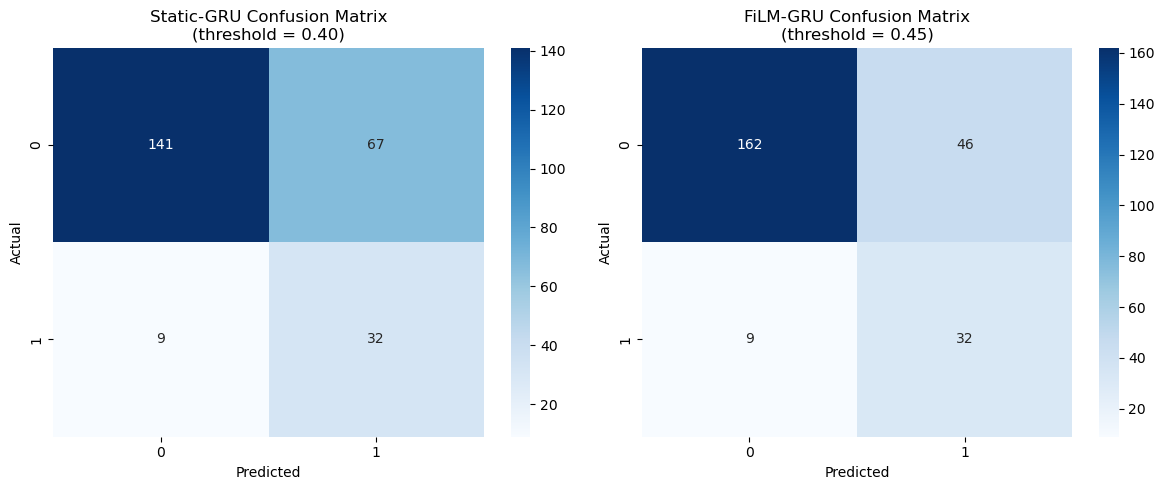

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute matrices
cm_static = confusion_matrix(y_true_static, (y_prob_static > best_t_static).astype(int))
cm_film   = confusion_matrix(y_true_film, (y_prob_film > best_t_film).astype(int))

plt.figure(figsize=(12,5))

# --- Static-GRU ---
plt.subplot(1,2,1)
sns.heatmap(cm_static, annot=True, fmt="d", cmap="Blues")
plt.title(f"Static-GRU Confusion Matrix\n(threshold = {best_t_static:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# --- FiLM-GRU ---
plt.subplot(1,2,2)
sns.heatmap(cm_film, annot=True, fmt="d", cmap="Blues")
plt.title(f"FiLM-GRU Confusion Matrix\n(threshold = {best_t_film:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

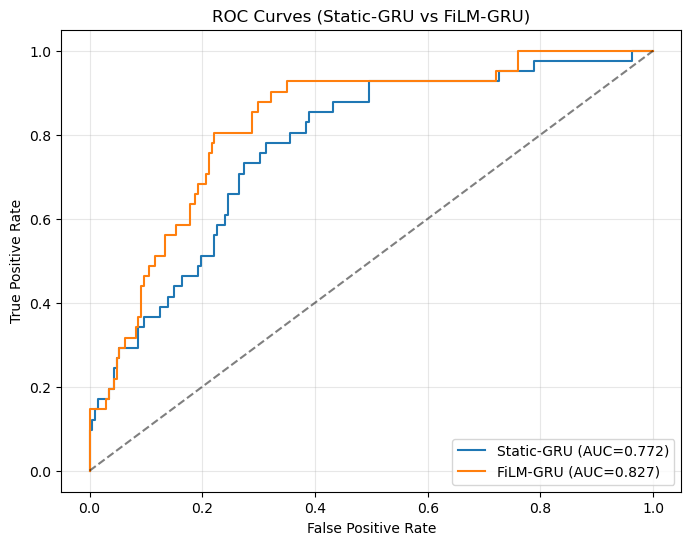

In [151]:
from sklearn.metrics import roc_curve, auc

fpr_s, tpr_s, _ = roc_curve(y_true_static, y_prob_static)
fpr_f, tpr_f, _ = roc_curve(y_true_film, y_prob_film)

auc_static = auc(fpr_s, tpr_s)
auc_film = auc(fpr_f, tpr_f)

plt.figure(figsize=(8,6))
plt.plot(fpr_s, tpr_s, label=f"Static-GRU (AUC={auc_static:.3f})")
plt.plot(fpr_f, tpr_f, label=f"FiLM-GRU (AUC={auc_film:.3f})")

plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Static-GRU vs FiLM-GRU)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [155]:
import pandas as pd

results_df = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1"],
    "Static-GRU": [
        metrics_static["Accuracy"],
        metrics_static["AUC"],
        metrics_static["Precision"],
        metrics_static["Recall"],
        metrics_static["F1"]
    ],
    "FiLM-GRU": [
        metrics_film["Accuracy"],
        metrics_film["AUC"],
        metrics_film["Precision"],
        metrics_film["Recall"],
        metrics_film["F1"]
    ],
})

results_df_rounded = results_df.copy()
results_df_rounded["Static-GRU"] = results_df_rounded["Static-GRU"].round(4)
results_df_rounded["FiLM-GRU"] = results_df_rounded["FiLM-GRU"].round(4)

results_df_rounded

,Metric,Static-GRU,FiLM-GRU
0,Accuracy,0.6948,0.7791
1,AUC,0.7724,0.8270
2,Precision,0.3232,0.4103
3,Recall,0.7805,0.7805
4,F1,0.4571,0.5378
